In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import likelihood
import pandas as pd
import numpy as np

### Example model and data

Models should have the form:
```
def some_model(param1,param2,param3,...other_args,...other_kwargs):
    return observable
```

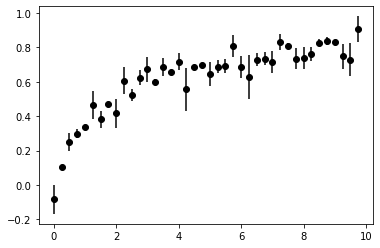

,X,Y,Y_stdev,residual,weighted_residual
0,0.00,-0.083946,-0.083946,-0.083946,1.0
1,0.25,0.105050,-0.006061,-0.006061,1.0
2,0.50,0.250501,0.050501,0.050501,1.0
3,0.75,0.298984,0.026257,0.026257,1.0
4,1.00,0.335014,0.001681,0.001681,1.0


In [23]:
def binding_model(K,X=None):
    """
    Simple, saturating binding curve.

    K: association constant
    X: vector of X concentrations
    """

    return K*X/(1 + K*X)

df = pd.read_csv("binding-curves_noise-0.050.csv",index_col=0)

fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")
plt.show()

df.head()

### Wrap the binding model
Anything except the fit parameters should be passed in via args and kwargs

In [3]:
lm = likelihood.ModelWrapper(binding_model)
lm.X = df.X

### Construct the fitter and do the fit

In [20]:
f = likelihood.MLFitter()
f.fit(model=lm.model,guesses=[1.0],y_obs=df.Y,)
print(f.success)
print(f.estimate)

True
[0.47813785]


### Alternate way to construct fitter and do fit

In [21]:
f = likelihood.MLFitter()
f.model = lm.model
f.guesses = [1.0]
f.y_obs = df.Y
f.fit()
print(f.success)
print(f.estimate)

True
[0.47813785]


### Add weighted residuals

In [22]:
f = likelihood.MLFitter()
f.fit(model=lm.model,y_obs=df.Y,y_stdev=df.Y_stdev)
print(f.success)
print(f.estimate)

True
[0.5029113]


### Plotting

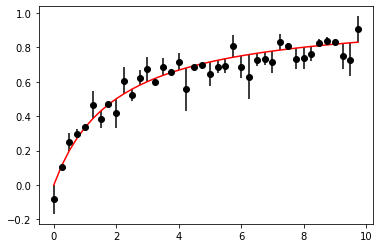

In [14]:
# Plot the fit
fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")
ax.plot(df.X,lm.model(f.estimate),"-",color='red')

### Corner plot

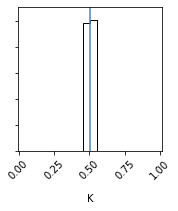

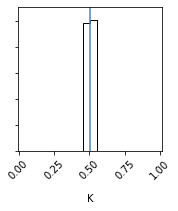

In [15]:
f.corner_plot()

### You can add parameter bounds and names
(These can also be set as arguments in the f.fit() call)


In [16]:
f = likelihood.MLFitter()
f.model = lm.model
f.guesses = [1.0]
f.y_obs = df.Y
f.y_stdev = df.Y_stdev
f.bounds = [[0],[np.inf]]
f.param_names = ["K"]
f.fit()
print(f.success)
print(f.estimate)

True
[0.5029113]


### Bayesian fitter

In [18]:
f = likelihood.BayesianFitter()
f.fit(model=lm.model,guesses=[1.0],y_obs=df.Y,y_stdev=df.Y_stdev)
print(f.success)
print(f.estimate)


True
[0.50298071]


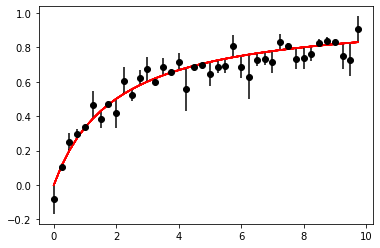

In [19]:
fig, ax = plt.subplots()
ax.errorbar(df.X,df.Y,yerr=df.Y_stdev,fmt="o",color="black")

# Plot 100 fits sampled from posterior
for i in range(0,len(f.samples),90):
    ax.plot(df.X,lm.model(f.samples[i,:]),"-",color='red',alpha=0.1)

In [24]:
lm.fit_parameters

{'K': <likelihood.fit_param.FitParameter at 0x1191bedd8>}